## Importing libraries and files

In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys

ann_arr = load_model('Arrival_time/Arrival_ANN_model_3.h5')
ann_end = load_model('End_time/End_ANN_model_8.h5')
ann_chg = load_model('Change_time/Change_ANN_model_3.h5')
#Section1
ann1 = load_model('Pressure_profiles_codes_section_1_regression/ANN_13.h5')
sc1 = pickle.load(open('Pressure_profiles_codes_section_1_regression/scaler_ANN.pkl', 'rb'))
#Section2
ann2 = load_model('Pressure_profiles_codes_section_2_regression/ANN_1.h5')
sc2 = pickle.load(open('Pressure_profiles_codes_section_2_regression/scaler_ANN.pkl', 'rb'))
#Section3
ann3 = load_model('Pressure_profiles_codes_section_3_regression/ANN_1.h5')
sc3 = pickle.load(open('Pressure_profiles_codes_section_3_regression/scaler_ANN.pkl', 'rb'))
#Section4
ann4 = load_model('Pressure_profiles_codes_section_4_regression/ANN_1.h5')
sc4 = pickle.load(open('Pressure_profiles_codes_section_4_regression/scaler_ANN.pkl', 'rb'))
#Section5
ann5 = load_model('Pressure_profiles_codes_section_5_regression/ANN_1.h5')
sc5 = pickle.load(open('Pressure_profiles_codes_section_5_regression/scaler_ANN.pkl', 'rb'))

## Input details

In [359]:
charge_mass = 16.4
time = 0.009
atm_pressure = 101200
domain_min = 0
domain_max = 7
mesh_size = 700
if np.sqrt(domain_min**2 + domain_max**2) > 30:
    print ("out of trained range")
    #sys.exit()

In [360]:
x_vals = np.linspace(domain_min, domain_max, mesh_size)
y_vals = np.linspace(domain_min, domain_max, mesh_size)
X, Y = np.meshgrid(x_vals, y_vals)
#generate standoff distances
Z = np.sqrt(X**2 + Y**2)
#reshape Z
c_d = Z.reshape(-1)
c_d = c_d.reshape(len (c_d), 1)
c_ud = np.unique(c_d)
print ('c_d shape', c_d.shape, 'c_ud shape', c_ud.shape)

c_d shape (490000, 1) c_ud shape (175902,)


In [361]:
d_s0 = np.array([])
d_s1 = np.array([])
d_s2 = np.array([])
d_s3 = np.array([])
d_s4 = np.array([])
d_s5 = np.array([])
print (d_s0, d_s1, d_s2, d_s3, d_s4, d_s5)
for d in c_ud:
    if 3 <= d <= 7:
        d_s1 = np.append(d_s1,d)
    elif 7 < d <= 13:
        d_s2 = np.append(d_s2,d)
    elif 13 < d <= 19:
        d_s3 = np.append(d_s3,d) 
    elif 19 < d <= 25:
        d_s4 = np.append(d_s4,d)
    elif 25 < d <= 30:
        d_s5 = np.append(d_s5,d)
    else:
        d_s0 = np.append(d_s0,d)
print ('0', d_s0.shape, '1', d_s1.shape, '2', d_s2.shape, '3',d_s3.shape, '4', d_s4.shape, '5', d_s5.shape)
d_s0 = d_s0.reshape(len (d_s0), 1)
d_s1 = d_s1.reshape(len (d_s1), 1)
d_s2 = d_s2.reshape(len (d_s2), 1)
d_s3 = d_s3.reshape(len (d_s3), 1)
d_s4 = d_s4.reshape(len (d_s4), 1)
print ('0', d_s0.shape, '1', d_s1.shape, '2', d_s2.shape, '3',d_s3.shape, '4', d_s4.shape, '5', d_s5.shape)

[] [] [] [] [] []
0 (25463,) 1 (105785,) 2 (44654,) 3 (0,) 4 (0,) 5 (0,)
0 (25463, 1) 1 (105785, 1) 2 (44654, 1) 3 (0, 1) 4 (0, 1) 5 (0,)


## d_s0

In [362]:
c_p0 = np.repeat(0, len(d_s0)).reshape(len(d_s0),1)
c_p0 = c_p0.flatten()
print (c_p0.shape)

(25463,)


## d_s1(edit)

In [363]:
#Charge mass array for initial parameter prediction
m_p1 = np.repeat(charge_mass, len(d_s1)).reshape(len(d_s1),1)
print ('m_p1', m_p1.shape)

c_arr1 = np.concatenate ((m_p1, d_s1), axis = 1)
#predict change, arrival and end times
change_time1 = ann_chg.predict(c_arr1)
print ('change_time1', len(change_time1), change_time1.shape)
#print (change_time1)
arrival_time1 = ann_arr.predict(c_arr1)
end_time1 = ann_end.predict(c_arr1)

d_s1_n = np.array([])
d_s1_f = np.array([])

#define phase change
if time < change_time1[0]:
    if time < arrival_time1[0]:
        d_s1_n = np.append(d_s1_n,d_s1[0])
    else:
        d_s1_f = np.append(d_s1_f,d_s1[0])
        c_ph1 = np.array([[0, 1]])
else:
    if time > end_time1[0]:
        d_s1_n = np.append(d_s1_n,d_s1[0])
    else:
        d_s1_f = np.append(d_s1_f,d_s1[0])
        c_ph1 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])

for index1 in range (1, len(change_time1)):
    if time < change_time1[index1]:
        if time < arrival_time1[index1]:
            d_s1_n = np.append(d_s1_n,d_s1[index1])
        else:
            d_s1_f = np.append(d_s1_f,d_s1[index1])
            c_ph1 = np.vstack((c_ph1,positive))
    else:
        if time > end_time1[index1]:
            d_s1_n = np.append(d_s1_n,d_s1[index1])
        else:
            d_s1_f = np.append(d_s1_f,d_s1[index1])
            c_ph1 = np.vstack((c_ph1,negative))

#Charge mass array
c_m1 = np.repeat(charge_mass, len(d_s1_f)).reshape(len(d_s1_f),1)
print ('c_m1', c_m1.shape)
#Time array
c_t1 = np.repeat(time, len(d_s1_f)).reshape(len(d_s1_f),1)
print ('c_t1', c_t1.shape)

d_s1_f = d_s1_f.reshape(len (d_s1_f), 1)
d_s1_n = d_s1_n.reshape(len (d_s1_n), 1)
        
print ('d_s1_f', d_s1_f.shape)
print ('d_s1_n', d_s1_n.shape)
print ('c_ph1', c_ph1.shape)

c_arr1_2 = np.concatenate ((c_m1, d_s1_f, c_t1, c_ph1), axis = 1)
c_arr1_2[:,0:3] = sc1.transform(c_arr1_2[:,0:3])
c_p1_f = ann1.predict(c_arr1_2)
c_p1_f = c_p1_f.flatten()
print (c_p1_f.shape)

c_p1_n = np.repeat(100000, len(d_s1_n))
print ('c_p1_n', c_p1_n.shape)
c_p1_n = c_p1_n.reshape(len(d_s1_n),1)
c_p1_n = c_p1_n.flatten()
print (c_p1_n.shape)

m_p1 (105785, 1)
3306/3306 [==============================] - 4s 1ms/step
change_time1 105785 (105785, 1)
3306/3306 [==============================] - 5s 1ms/step
c_m1 (86797, 1)
c_t1 (86797, 1)
d_s1_f (86797, 1)
d_s1_n (18988, 1)
c_ph1 (86797, 2)
2713/2713 [==============================] - 7s 2ms/step
(86797,)
c_p1_n (18988,)
(18988,)


## d_s2(edit)

In [365]:
#Charge mass array for initial parameter prediction
m_p2 = np.repeat(charge_mass, len(d_s2)).reshape(len(d_s2),1)

c_arr2 = np.concatenate ((m_p2, d_s2), axis = 1)
#predict change, arrival and end times
change_time2 = ann_chg.predict(c_arr2)
arrival_time2 = ann_arr.predict(c_arr2)
end_time2 = ann_end.predict(c_arr2)

d_s2_n = np.array([])
d_s2_f = np.array([])

#define phase change
if time < change_time2[0]:
    if time < arrival_time2[0]:
        d_s2_n = np.append(d_s2_n,d_s2[0])
    else:
        d_s2_f = np.append(d_s2_f,d_s2[0])
        c_ph2 = np.array([[0, 1]])
else:
    if time > end_time2[0]:
        d_s2_n = np.append(d_s2_n,d_s2[0])
    else:
        d_s2_f = np.append(d_s2_f,d_s2[0])
        c_ph2 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])

for index2 in range (1, len(change_time2)):
    if time < change_time2[index2]:
        if time < arrival_time2[index2]:
            d_s2_n = np.append(d_s2_n,d_s2[index2])
        else:
            d_s2_f = np.append(d_s2_f,d_s2[index2])
            c_ph2 = np.vstack((c_ph2,positive))
    else:
        if time > end_time2[index2]:
            d_s2_n = np.append(d_s2_n,d_s2[index2])
        else:
            d_s2_f = np.append(d_s2_f,d_s2[index2])
            c_ph2 = np.vstack((c_ph2,negative))

#Charge mass array
c_m2 = np.repeat(charge_mass, len(d_s2_f)).reshape(len(d_s2_f),1)
#Time array
c_t2 = np.repeat(time, len(d_s2_f)).reshape(len(d_s2_f),1)

d_s2_f = d_s2_f.reshape(len (d_s2_f), 1)
d_s2_n = d_s2_n.reshape(len (d_s2_n), 1)

print ('d_s2_f', d_s2_f.shape)
print ('d_s2_n', d_s2_n.shape)
print ('c_ph2', c_ph2.shape)

#c_arr2_2 = np.concatenate ((c_m2, d_s2_f, c_t2, c_ph2), axis = 1)
#c_arr2_2[:,0:3] = sc2.transform(c_arr2_2[:,0:3])
#c_p2_f = ann2.predict(c_arr2_2)
#c_p2_f = c_p2_f.flatten()
#print (c_p2_f.shape)

c_p2_n = np.repeat(100000, len(d_s2_n)).reshape(len(d_s2_n),1)
c_p2_n = c_p2_n.flatten()
print (c_p2_n.shape)

1396/1396 [==============================] - 2s 1ms/step
d_s2_f (0, 1)
d_s2_n (44654, 1)
c_ph2 (193748, 2)
(44654,)


## d_s3(edit)

In [350]:
#Charge mass array
m_p3 = np.repeat(charge_mass, len(d_s3)).reshape(len(d_s3),1)

c_arr3 = np.concatenate ((m_p3, d_s3), axis = 1)
#predict change, arrival and end times
change_time3 = ann_chg.predict(c_arr3)
arrival_time3 = ann_arr.predict(c_arr3)
end_time3 = ann_end.predict(c_arr3)

d_s3_n = np.array([])
d_s3_f = np.array([])

#define phase change
if time < change_time3[0]:
    if time < arrival_time3[0]:
        d_s3_n = np.append(d_s3_n,d_s3[0])
    else:
        d_s3_f = np.append(d_s3_f,d_s3[0])
        c_ph3 = np.array([[0, 1]])
else:
    if time > end_time3[0]:
        d_s3_n = np.append(d_s3_n,d_s3[0])
    else:
        d_s3_f = np.append(d_s3_f,d_s3[0])
        c_ph3 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])

for index3 in range (1, len(change_time3)):
    if time < change_time3[index3]:
        if time < arrival_time3[index3]:
            d_s3_n = np.append(d_s3_n,d_s3[index3])
        else:
            d_s3_f = np.append(d_s3_f,d_s3[index3])
            c_ph3 = np.vstack((c_ph3,positive))
    else:
        if time > end_time3[index3]:
            d_s3_n = np.append(d_s3_n,d_s3[index3])
        else:
            d_s3_f = np.append(d_s3_f,d_s3[index3])
            c_ph3 = np.vstack((c_ph3,negative))

#Charge mass array
c_m3 = np.repeat(charge_mass, len(d_s3_f)).reshape(len(d_s3_f),1)
#Time array
c_t3 = np.repeat(time, len(d_s3_f)).reshape(len(d_s3_f),1)

d_s3_f = d_s3_f.reshape(len (d_s3_f), 1)
d_s3_n = d_s3_n.reshape(len (d_s3_n), 1)

print ('d_s3_f', d_s3_f.shape)
print ('d_s3_n', d_s3_n.shape)
print ('c_ph3', c_ph3.shape)

#c_arr3_2 = np.concatenate ((c_m3, d_s3_f, c_t3, c_ph3), axis = 1)
#c_arr3_2[:,0:3] = sc3.transform(c_arr3_2[:,0:3])
#c_p3_f = ann3.predict(c_arr3_2)
#c_p3_f = c_p3_f.flatten()
#print (c_p3_f.shape)

c_p3_n = np.repeat(100000, len(d_s3_n)).reshape(len(d_s3_n),1)
c_p3_n = c_p3_n.flatten()
print (c_p3_n.shape)

11603/11603 [==============================] - 18s 2ms/step
d_s3_f (0, 1)
d_s3_n (371280, 1)
c_ph3 (16303, 2)
(371280,)


## d_s3

In [182]:
#Charge mass array
c_m3 = np.repeat(charge_mass, len(d_s3)).reshape(len(d_s3),1)
#Time array
c_t3 = np.repeat(time, len(d_s3)).reshape(len(d_s3),1)
c_arr3 = np.concatenate ((c_m3, d_s3), axis = 1)
#predict change, arrival and end times
change_time3 = ann_chg.predict(c_arr3)
arrival_time3 = ann_arr.predict(c_arr3)
end_time3 = ann_end.predict(c_arr3)

#define phase change
if time < change_time3[0]:
    c_ph3 = np.array([[0, 1]])
else:
    c_ph3 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])
for c_time in change_time3[1:]:
    if time < c_time:
        c_ph3=np.vstack((c_ph3,positive))
    else:
        c_ph3=np.vstack((c_ph3,negative))

c_arr3_2 = np.concatenate ((c_m3, d_s3, c_t3, c_ph3), axis = 1)
c_arr3_2[:,0:3] = sc3.transform(c_arr3_2[:,0:3])
c_p3 = ann3.predict(c_arr3_2)
c_p3 = c_p3.flatten()
print (c_p3.shape)

510/510 [==============================] - 1s 2ms/step
(16303,)


## d_s4(edit)

In [352]:
#Charge mass array
m_p4 = np.repeat(charge_mass, len(d_s4)).reshape(len(d_s4),1)

c_arr4 = np.concatenate ((m_p4, d_s4), axis = 1)
#predict change, arrival and end times
change_time4 = ann_chg.predict(c_arr4)
arrival_time4 = ann_arr.predict(c_arr4)
end_time4 = ann_end.predict(c_arr4)

d_s4_n = np.array([])
d_s4_f = np.array([])

#define phase change
if time < change_time4[0]:
    if time < arrival_time4[0]:
        d_s4_n = np.append(d_s4_n,d_s4[0])
    else:
        d_s4_f = np.append(d_s4_f,d_s4[0])
        c_ph4 = np.array([[0, 1]])
else:
    if time > end_time4[0]:
        d_s4_n = np.append(d_s4_n,d_s4[0])
    else:
        d_s4_f = np.append(d_s4_f,d_s4[0])
        c_ph4 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])

for index4 in range (1, len(change_time4)):
    if time < change_time4[index4]:
        if time < arrival_time4[index4]:
            d_s4_n = np.append(d_s4_n,d_s4[index4])
        else:
            d_s4_f = np.append(d_s4_f,d_s4[index4])
            c_ph4 = np.vstack((c_ph4,positive))
    else:
        if time > end_time4[index4]:
            d_s4_n = np.append(d_s4_n,d_s4[index4])
        else:
            d_s4_f = np.append(d_s4_f,d_s4[index4])
            c_ph4 = np.vstack((c_ph4,negative))

#Charge mass array
c_m4 = np.repeat(charge_mass, len(d_s4_f)).reshape(len(d_s4_f),1)
#Time array
c_t4 = np.repeat(time, len(d_s4_f)).reshape(len(d_s4_f),1)

d_s4_f = d_s4_f.reshape(len (d_s4_f), 1)
d_s4_n = d_s4_n.reshape(len (d_s4_n), 1)

print ('d_s4_f', d_s4_f.shape)
print ('d_s4_n', d_s4_n.shape)
#print ('c_ph4', c_ph4.shape)

#c_arr4_2 = np.concatenate ((c_m4, d_s4_f, c_t4, c_ph4), axis = 1)
#c_arr4_2[:,0:3] = sc4.transform(c_arr4_2[:,0:3])
#c_p4_f = ann4.predict(c_arr4_2)
#c_p4_f = c_p4_f.flatten()
#print (c_p4_f.shape)

c_p4_n = np.repeat(100000, len(d_s4_n)).reshape(len(d_s4_n),1)
c_p4_n = c_p4_n.flatten()
print (c_p4_n.shape)

2083/2083 [==============================] - 3s 2ms/step
d_s4_f (0, 1)
d_s4_n (66656, 1)
(66656,)


## d_s5

In [ ]:
#Charge mass array
c_m5 = np.repeat(charge_mass, len(d_s5)).reshape(len(d_s5),1)
#Time array
c_t5 = np.repeat(time, len(d_s5)).reshape(len(d_s5),1)
c_arr5 = np.concatenate ((c_m5, d_s5), axis = 1)
#predict change, arrival and end times
change_time5 = ann_chg.predict(c_arr5)
arrival_time5 = ann_arr.predict(c_arr5)
end_time5 = ann_end.predict(c_arr5)

#define phase change
if time < change_time5[0]:
    c_ph5 = np.array([[0, 1]])
else:
    c_ph5 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])
for c_time in change_time3[1:]:
    if time < c_time:
        c_ph5=np.vstack((c_ph5,positive))
    else:
        c_ph5=np.vstack((c_ph5,negative))

c_arr5_2 = np.concatenate ((c_m5, d_s5, c_t5, c_ph5), axis = 1)
c_arr5_2[:,0:3] = sc5.transform(c_arr5_2[:,0:3])
c_p5 = ann5.predict(c_arr5_2)
c_p5 = c_p5.flatten()
print (c_p5.shape)

In [366]:
d_s0 = d_s0.flatten()
d_s1_f = d_s1_f.flatten()
d_s1_n = d_s1_n.flatten()
#d_s2_f = d_s2_f.flatten()
d_s2_n = d_s2_n.flatten()
#d_s3_n = d_s3_n.flatten()
#d_s4_n = d_s4_n.flatten()
#d_s3 = d_s3.flatten()
#d_s4 = d_s4.flatten()
#d_s5 = d_s5.flatten()
print (d_s0.shape, d_s1_f.shape, d_s1_n.shape, d_s2_n.shape)
value_map = dict(zip(d_s0, c_p0))
value_map.update(dict(zip(d_s1_f, c_p1_f)))
value_map.update(dict(zip(d_s1_n, c_p1_n)))
#value_map.update(dict(zip(d_s2_f, c_p2_f)))
value_map.update(dict(zip(d_s2_n, c_p2_n)))
#value_map.update(dict(zip(d_s3_n, c_p3_n)))
#value_map.update(dict(zip(d_s4_n, c_p4_n)))
#value_map.update(dict(zip(d_s5, c_p5)))
print (len(value_map))
original_replaced = np.vectorize(value_map.get)(c_d)
print("Replaced array:", original_replaced)

(25463,) (86797,) (18988,) (44654,)
175902
Replaced array: [[     0]
 [     0]
 [     0]
 ...
 [100000]
 [100000]
 [100000]]


In [354]:
print (min(c_p1_f))
print (min(c_p2_f))

print (max(c_p1_f))
print (max(c_p2_f))

84372.836
84173.13
102877.38
135267.31


In [367]:
c_p = original_replaced.reshape(700, 700)
print (c_p)

[[     0      0      0 ... 100000 100000 100000]
 [     0      0      0 ... 100000 100000 100000]
 [     0      0      0 ... 100000 100000 100000]
 ...
 [100000 100000 100000 ... 100000 100000 100000]
 [100000 100000 100000 ... 100000 100000 100000]
 [100000 100000 100000 ... 100000 100000 100000]]


In [ ]:
# convert array into dataframe
DF = pd.DataFrame(c_p)
 
# save the dataframe as a csv file
DF.to_csv("data1.csv")

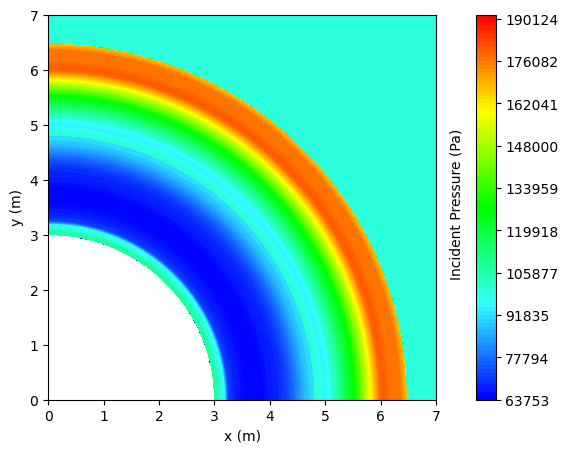

In [369]:
import matplotlib
from scipy.interpolate import griddata

cdict = {'red': ((0.0, 0.0, 0.0),
                 (0.25, 0.2, 0.2),
                 (0.5, 0.0, 0.0),
                 (0.75, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green':((0.0, 0.0, 0.0),
                 (0.25, 1.0, 1.0),
                 (0.5, 1.0, 1.0),
                 (0.75, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
        'blue': ((0.0, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5, 0.0, 0.0),
                 (0.75, 0.0, 0.0),
                 (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

#rng = np.random.default_rng()
#points = rng.random((1000, 2))

#c_p_interpolate = griddata(points, c_p, (X,Y), method = 'linear')

fig, ax = plt.subplots(figsize=(6.5,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax1 = fig.add_axes([left, bottom, width, height])
levels = np.linspace(63753, 191400, 101)
cp = plt.contourf(X, Y, c_p, levels= levels, cmap = my_cmap) # c_p_interpolate
fig.colorbar(cp, pad =0.08)
text = 'Incident Pressure (Pa)'
plt.gcf().text(0.76, 0.35, text, fontsize=10, rotation = 90, rotation_mode = 'anchor')
#plt.gcf().text(0.8, 0.87, '(Pa)', fontsize=10)

#ax.set_title('Incident Pressure Contour Plot')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
plt.show()